In [8]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd
from tqdm import tqdm

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score , cohen_kappa_score, roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

Cargamos el pdf con las variables estandarizadas mediante RobustScaler y manteniendo todo el tipo de las variables en float.

In [9]:
df_esta = pd.read_pickle("data/df_robust.pkl")
df_esta.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,2.191080,-0.224744,0.585071,1.0,1.0,0.0,0.0,0.0
1,0.039430,-0.269055,0.182947,1.0,0.0,0.0,0.0,0.0
2,-0.223026,-0.063254,-0.351702,1.0,0.0,0.0,1.0,0.0
3,-0.353069,1.504177,-0.391840,1.0,1.0,0.0,1.0,0.0
4,1.565134,-0.141273,0.755879,1.0,1.0,0.0,1.0,0.0


In [10]:
X1 = df_esta.drop("fraud", axis = 1)
y1 = df_esta["fraud"]

In [11]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.2, random_state = 42)

In [12]:
# creamos el objeto del modelo, al igual que hacíamos en la regresión lineal
arbol = DecisionTreeClassifier(random_state =0)

# ajustamos el modelo, igual que en la regresión lienal. 
arbol.fit(x_train1, y_train1)

DecisionTreeClassifier(random_state=0)

In [13]:
max_features = np.sqrt(len(x_train1.columns))
max_features

2.6457513110645907

In [14]:
# max depth
print(arbol.tree_.max_depth)

7


In [15]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test_esta = arbol.predict(x_test1)
y_pred_train_esta = arbol.predict(x_train1)

In [16]:
def metricas(clases_reales_test, clases_predichas_test, clases_reales_train, clases_predichas_train, modelo):
    
    # para el test
    accuracy_test = accuracy_score(clases_reales_test, clases_predichas_test)
    precision_test = precision_score(clases_reales_test, clases_predichas_test)
    recall_test = recall_score(clases_reales_test, clases_predichas_test)
    f1_test = f1_score(clases_reales_test, clases_predichas_test)
    kappa_test = cohen_kappa_score(clases_reales_test, clases_predichas_test)

    # para el train
    accuracy_train = accuracy_score(clases_reales_train, clases_predichas_train)
    precision_train = precision_score(clases_reales_train, clases_predichas_train)
    recall_train = recall_score(clases_reales_train, clases_predichas_train)
    f1_train = f1_score(clases_reales_train, clases_predichas_train)
    kappa_train = cohen_kappa_score(clases_reales_train, clases_predichas_train)
    

    
    df = pd.DataFrame({"accuracy": [accuracy_test, accuracy_train], 
                       "precision": [precision_test, precision_train],
                       "recall": [recall_test, recall_train], 
                       "f1": [f1_test, f1_train],
                       "kapppa": [kappa_test, kappa_train],
                       "set": ["test", "train"]})
    
    df["modelo"] = modelo
    return df

In [17]:

dt_results1 = metricas(y_test1, y_pred_test_esta, y_train1, y_pred_train_esta, "Decission Tree Esta I")
dt_results1

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.999985,0.999943,0.999885,0.999914,0.999906,test,Decission Tree Esta I
1,1.000000,1.000000,1.000000,1.000000,1.000000,train,Decission Tree Esta I


In [18]:
# lo primero que tenemos que hacer es definir un diccionario con los hiperparámetros que queremos modificar y los valores que queremos 

param = {"max_depth": [3,5,7], # para reducir overfitting, reducimos la profundidad considerando que el máximo era 7
        "max_features": [1,2,3],# reducimos las variables  
        "min_samples_split": [10, 50, 100],
        "min_samples_leaf": [10,50,100]} 

In [19]:
# una vez creado el diccionario iniciaremos el modelo con GridSearch

gs = GridSearchCV(
            estimator=DecisionTreeClassifier(random_state= 42), # tipo de modelo que queremos hacer
            param_grid= param, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=-1)

In [20]:
gs.fit(x_train1, y_train1)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, 7], 'max_features': [1, 2, 3],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100]},
             verbose=-1)

In [21]:
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeClassifier(max_depth=7, max_features=3, min_samples_leaf=10,
                       min_samples_split=50, random_state=42)

In [22]:
y_pred_test_esta2 = mejor_modelo.predict(x_test1)
y_pred_train_esta2 = mejor_modelo.predict(x_train1)

In [23]:
dt_results2 = metricas(y_test1, y_pred_test_esta2, y_train1,  y_pred_train_esta2, "Decision tree Esta II")
dt_results2

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.999565,0.998564,0.996446,0.997504,0.997265,test,Decision tree Esta II
1,0.999665,0.999026,0.997141,0.998083,0.997899,train,Decision tree Esta II


In [24]:
# juntamos los dataframes de los dos modelos

df_decision_results = pd.concat([dt_results1, dt_results2], axis = 0)
df_decision_results

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.999985,0.999943,0.999885,0.999914,0.999906,test,Decission Tree Esta I
1,1.000000,1.000000,1.000000,1.000000,1.000000,train,Decission Tree Esta I
0,0.999565,0.998564,0.996446,0.997504,0.997265,test,Decision tree Esta II
1,0.999665,0.999026,0.997141,0.998083,0.997899,train,Decision tree Esta II


In [25]:
# vamos a crearnos un dataframe 
importancia_predictores_esta = pd.DataFrame(
                            {'predictor': x_train1.columns,
                             'importancia': mejor_modelo.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores_esta.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores_esta

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
2,ratio_to_median_purchase_price,0.578445
0,distance_from_home,0.135169
5,used_pin_number,0.103016
4,used_chip,0.081919
1,distance_from_last_transaction,0.040173
6,online_order,0.037107
3,repeat_retailer,0.024170


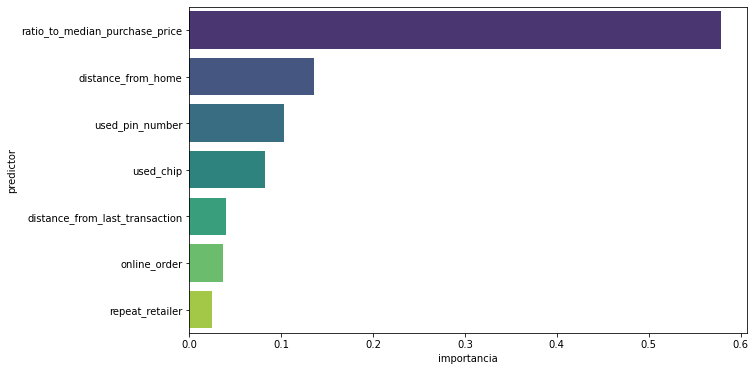

In [26]:
plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores_esta, palette="viridis");
plt.show()

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
999995    0.0
999996    0.0
999997    0.0
999998    0.0
999999    0.0
Name: fraud, Length: 1000000, dtype: float64

In [30]:
bosque = gs.best_estimator_
bosque

DecisionTreeClassifier(max_depth=7, max_features=3, min_samples_leaf=10,
                       min_samples_split=50, random_state=42)

In [31]:
y_pred_test_rf = bosque.predict(x_test1)
y_pred_train_rf = bosque.predict(x_train1)

In [32]:
dt_results = metricas(y_test1, y_pred_test_rf,y_train1,  y_pred_train_rf, "Random Forest")
dt_results

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.999565,0.998564,0.996446,0.997504,0.997265,test,Random Forest
1,0.999665,0.999026,0.997141,0.998083,0.997899,train,Random Forest


In [33]:
df_total = pd.concat([df_decision_results, dt_results], axis = 0)
df_total


,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.999985,0.999943,0.999885,0.999914,0.999906,test,Decission Tree Esta I
1,1.000000,1.000000,1.000000,1.000000,1.000000,train,Decission Tree Esta I
0,0.999565,0.998564,0.996446,0.997504,0.997265,test,Decision tree Esta II
1,0.999665,0.999026,0.997141,0.998083,0.997899,train,Decision tree Esta II
0,0.999565,0.998564,0.996446,0.997504,0.997265,test,Random Forest
1,0.999665,0.999026,0.997141,0.998083,0.997899,train,Random Forest
